# 04 — Feature Matrix (All Zones)

**Phase 2a: Feature Engineering**

## What you'll learn

- How to **build feature matrices for all 5 zones**
- How to inspect **data quality** across zones
- How to check **correlations** between features
- What the final training dataset looks like before modeling

## The big picture

| Group | Source | Frequency | # Features | Zone-specific? |
|-------|--------|-----------|------------|----------------|
| Calendar | Timestamps | Hourly | 7 | No |
| Weather | Frost API | Hourly | 5 | **Yes** |
| Price (EUR) | Nord Pool | Hourly | 9 | **Yes** |
| Price (NOK) | EUR × FX | Hourly | 18 | **Yes** |
| Commodities | yfinance | Daily → hourly | 5 | No |
| FX | Norges Bank | Daily → hourly | 1 | No |
| Statnett | Statnett API | Daily → hourly | 4 | No |
| Reservoir | NVE | Weekly → hourly | 5 | **Yes** |

Price features include EUR/MWh (market standard) plus NOK/MWh and NOK/kWh with full lag/rolling/diff sets.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent) if Path("../src").exists() else str(Path.cwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.features.build_features import build_all_zones_feature_matrix, ZONE_LABELS

START, END = "2022-01-01", "2026-01-01"

## Build feature matrices for all 5 zones

This calls `build_feature_matrix()` for each zone. Weather and reservoir data are zone-specific; commodities, FX, and Statnett are national.

In [2]:
all_dfs = build_all_zones_feature_matrix(START, END)

print(f"Built features for {len(all_dfs)}/{5} zones\n")
print(f"{'Zone':<8s} {'Label':<20s} {'Rows':>8s} {'Cols':>5s} {'Missing':>10s} {'Missing %':>10s}")
print("-" * 65)
for zone, df in all_dfs.items():
    missing = df.isna().sum().sum()
    total = df.shape[0] * df.shape[1]
    print(f"{zone:<8s} {ZONE_LABELS[zone]:<20s} {df.shape[0]:>8,} {df.shape[1]:>5d} {missing:>10,} {missing/total*100:>9.3f}%")

Built features for 5/5 zones

Zone     Label                    Rows  Cols    Missing  Missing %
-----------------------------------------------------------------
NO_1     Øst-Norge (Oslo)       35,065    68      1,667     0.070%
NO_2     Sør-Norge (Kristiansand)   35,065    75      1,667     0.063%
NO_3     Midt-Norge (Trondheim)   35,065    68      1,667     0.070%
NO_4     Nord-Norge (Tromsø)    35,065    74      1,667     0.064%
NO_5     Vest-Norge (Bergen)    35,065    63      1,667     0.075%


## Compare features across zones

In [3]:
# Summary statistics per zone
zone_specific = ["temperature", "wind_speed", "precipitation",
                  "reservoir_filling_pct", "reservoir_vs_median"]

for feat in zone_specific:
    print(f"\n{feat}:")
    for zone, df in all_dfs.items():
        if feat in df.columns:
            vals = df[feat].dropna()
            print(f"  {zone}: mean={vals.mean():8.2f}, min={vals.min():8.2f}, max={vals.max():8.2f}")


temperature:
  NO_1: mean=    7.76, min=  -22.90, max=   32.60
  NO_2: mean=    8.50, min=  -21.10, max=   28.70
  NO_3: mean=    6.51, min=  -17.50, max=   31.90
  NO_4: mean=    4.27, min=  -13.90, max=   30.00
  NO_5: mean=    9.02, min=   -9.30, max=   30.40

wind_speed:
  NO_1: mean=    2.60, min=    0.00, max=   12.10
  NO_2: mean=    3.98, min=    0.00, max=   16.30
  NO_3: mean=    2.48, min=    0.00, max=   16.10
  NO_4: mean=    3.37, min=    0.00, max=   15.90
  NO_5: mean=    3.45, min=    0.10, max=   22.30

precipitation:
  NO_1: mean=    0.10, min=    0.00, max=   32.50
  NO_2: mean=    0.15, min=    0.00, max=   56.90
  NO_3: mean=    0.11, min=    0.00, max=   12.20
  NO_4: mean=    0.15, min=   -0.10, max=   14.10
  NO_5: mean=    0.29, min=   -0.40, max=   18.80

reservoir_filling_pct:
  NO_1: mean=    0.61, min=    0.08, max=    1.02
  NO_2: mean=    0.59, min=    0.19, max=    0.87
  NO_3: mean=    0.62, min=    0.11, max=    0.94
  NO_4: mean=    0.66, min=    0.

## Missing values across zones

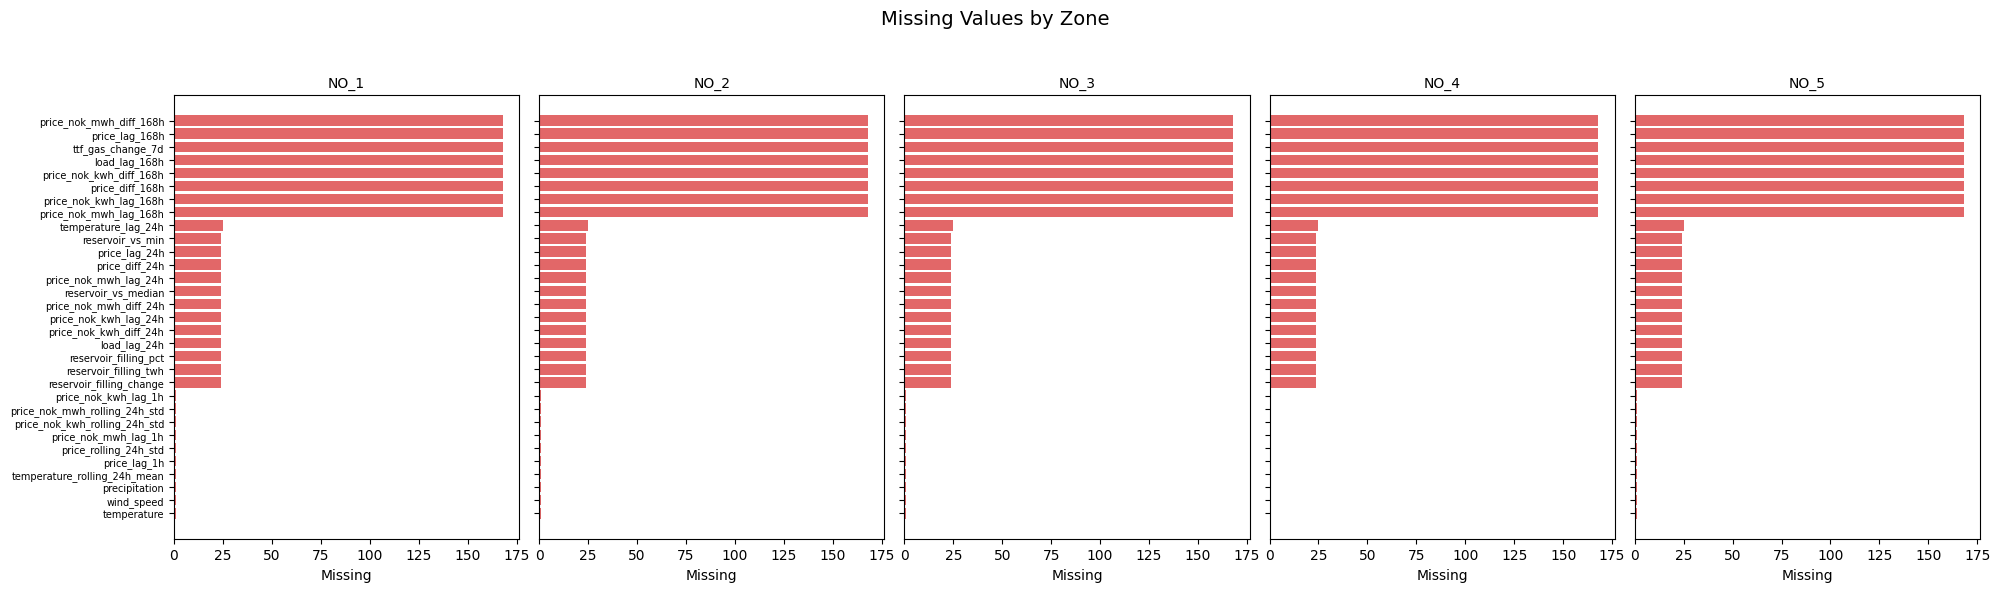

In [4]:
fig, axes = plt.subplots(1, len(all_dfs), figsize=(4 * len(all_dfs), 6), sharey=True)
if len(all_dfs) == 1:
    axes = [axes]

for i, (zone, df) in enumerate(all_dfs.items()):
    ax = axes[i]
    missing = df.isna().sum()
    missing_nz = missing[missing > 0].sort_values()
    if len(missing_nz) > 0:
        ax.barh(range(len(missing_nz)), missing_nz.values, color="tab:red", alpha=0.7)
        ax.set_yticks(range(len(missing_nz)))
        ax.set_yticklabels(missing_nz.index, fontsize=7)
    else:
        ax.text(0.5, 0.5, "None!", ha="center", va="center", transform=ax.transAxes)
    ax.set_title(f"{zone}", fontsize=10)
    ax.set_xlabel("Missing")

fig.suptitle("Missing Values by Zone", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Correlation heatmap (pick one zone)

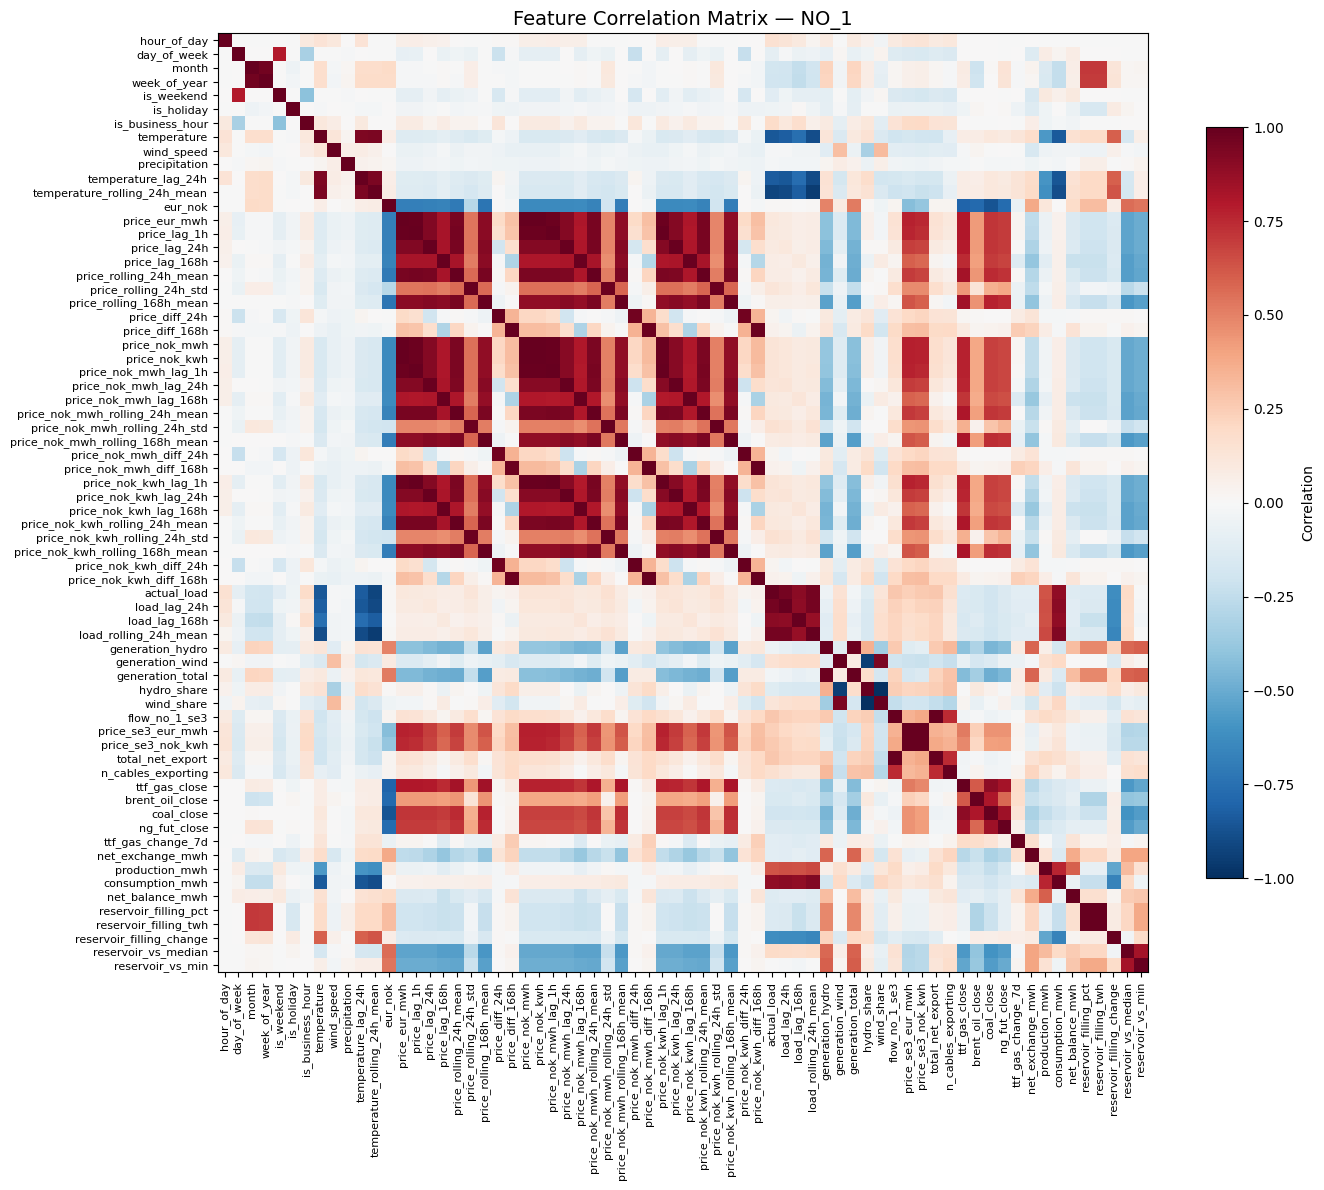

Highly correlated pairs (|r| > 0.85):
  price_nok_mwh                       price_nok_kwh                       r=+1.000 ← redundant
  price_nok_mwh_lag_1h                price_nok_kwh_lag_1h                r=+1.000 ← redundant
  price_nok_mwh_lag_24h               price_nok_kwh_lag_24h               r=+1.000 ← redundant
  price_nok_mwh_lag_168h              price_nok_kwh_lag_168h              r=+1.000 ← redundant
  price_nok_mwh_rolling_24h_mean      price_nok_kwh_rolling_24h_mean      r=+1.000 ← redundant
  price_nok_mwh_rolling_24h_std       price_nok_kwh_rolling_24h_std       r=+1.000 ← redundant
  price_nok_mwh_rolling_168h_mean     price_nok_kwh_rolling_168h_mean     r=+1.000 ← redundant
  price_nok_mwh_diff_24h              price_nok_kwh_diff_24h              r=+1.000 ← redundant
  price_nok_mwh_diff_168h             price_nok_kwh_diff_168h             r=+1.000 ← redundant
  flow_no_1_se3                       total_net_export                    r=+1.000 ← redundant
  reservoir_

In [5]:
# Use first zone for correlation
demo_zone = list(all_dfs.keys())[0]
df = all_dfs[demo_zone]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(corr.values, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90, fontsize=8)
ax.set_yticklabels(numeric_cols, fontsize=8)
plt.colorbar(im, ax=ax, label="Correlation", shrink=0.8)
ax.set_title(f"Feature Correlation Matrix — {demo_zone}", fontsize=14)
plt.tight_layout()
plt.show()

# Find high correlations
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high = [(i, c, round(upper.loc[i, c], 3))
        for c in upper.columns for i in upper.index
        if pd.notna(upper.loc[i, c]) and abs(upper.loc[i, c]) > 0.85]
high.sort(key=lambda x: abs(x[2]), reverse=True)

if high:
    print("Highly correlated pairs (|r| > 0.85):")
    for f1, f2, r in high:
        flag = " ← redundant" if abs(r) > 0.95 else ""
        print(f"  {f1:<35s} {f2:<35s} r={r:+.3f}{flag}")

## Feature distributions

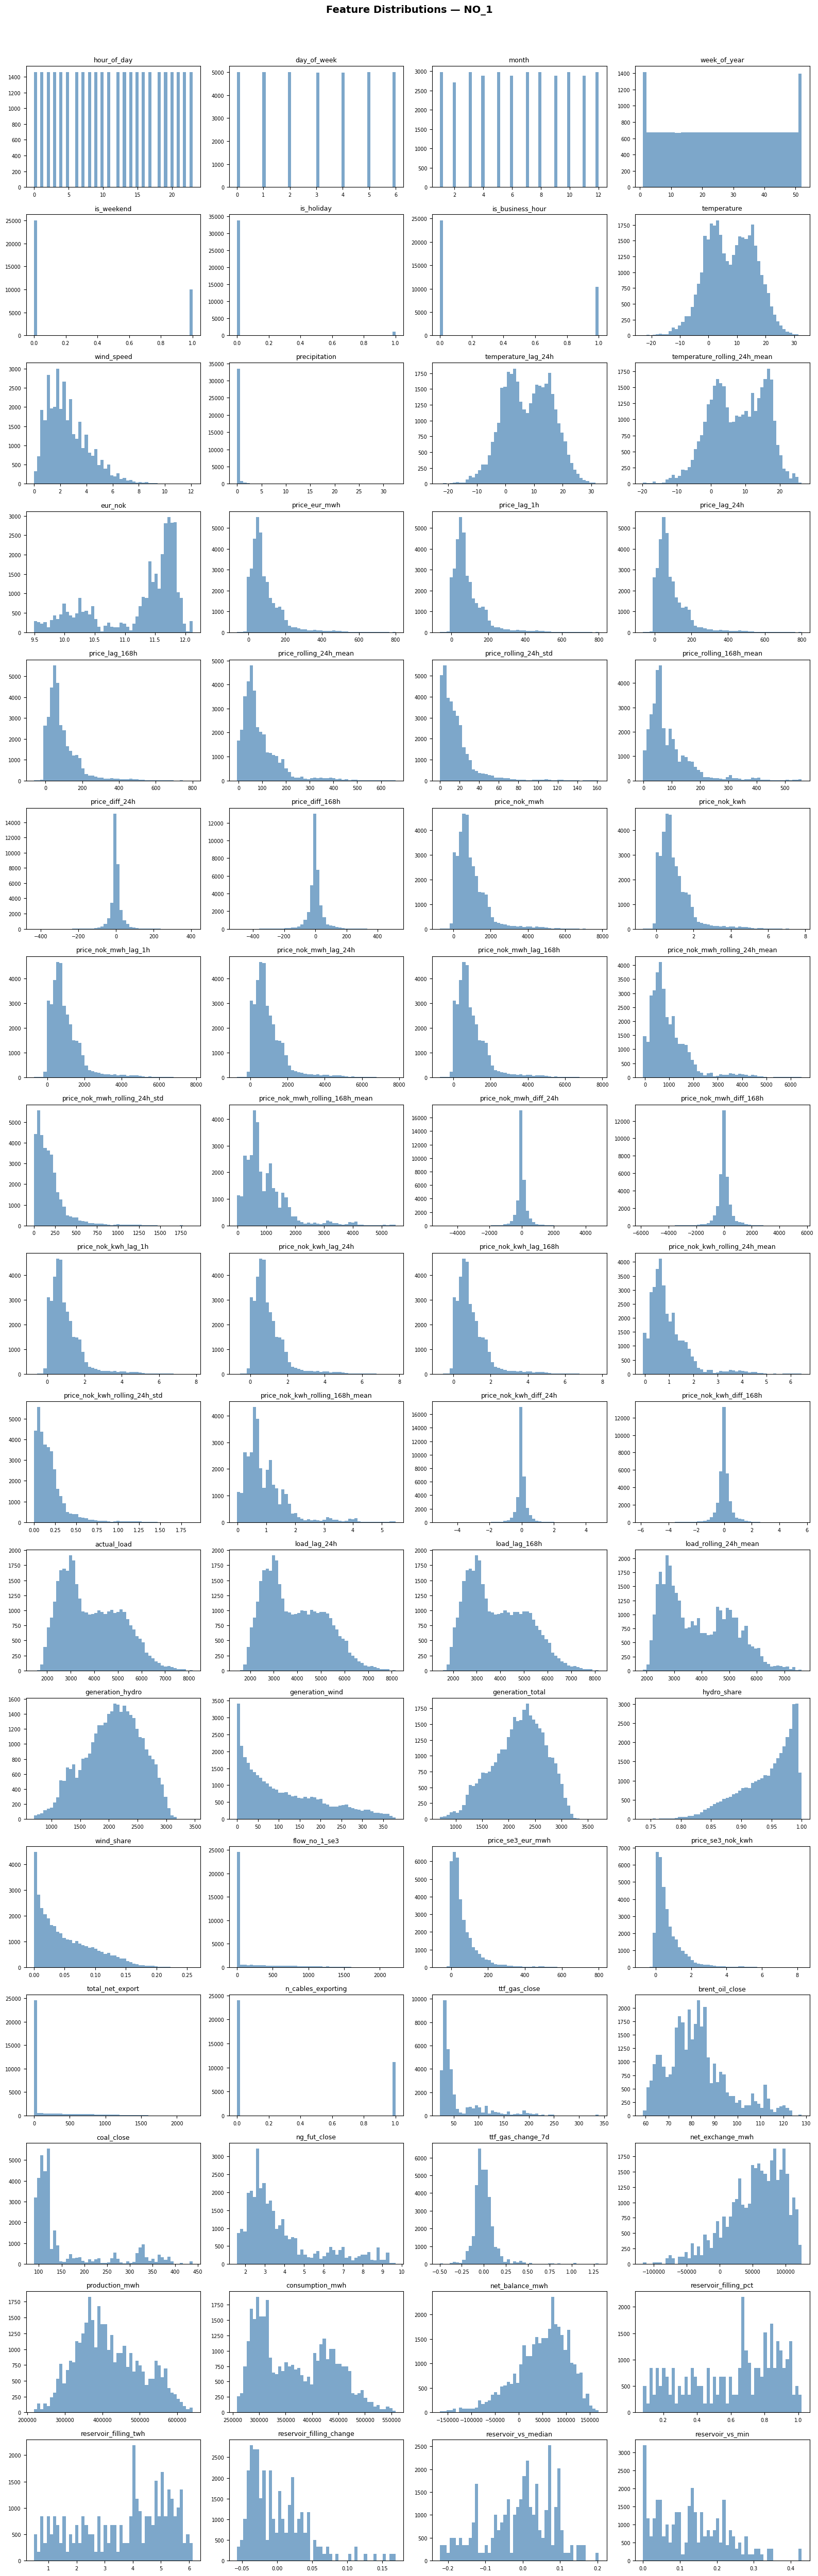

In [6]:
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes_flat = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes_flat[i]
    data = df[col].dropna()
    ax.hist(data, bins=50, color="steelblue", alpha=0.7, edgecolor="none")
    ax.set_title(col, fontsize=9)
    ax.tick_params(labelsize=7)

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

fig.suptitle(f"Feature Distributions — {demo_zone}", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Cached output

Each zone's feature matrix is saved to `data/processed/` as Parquet.

In [7]:
processed_dir = Path("../data/processed")
for f in sorted(processed_dir.glob("features_*.parquet")):
    size_kb = f.stat().st_size / 1024
    print(f"{f.name}: {size_kb:.0f} KB")

features_NO_1_2022-01-01_2026-01-01.parquet: 11369 KB
features_NO_2_2022-01-01_2026-01-01.parquet: 11650 KB
features_NO_3_2022-01-01_2026-01-01.parquet: 10849 KB
features_NO_4_2022-01-01_2026-01-01.parquet: 12118 KB
features_NO_5_2022-01-01_2026-01-01.parquet: 7864 KB


## Key takeaways

- **~45 features** per zone from 7 data sources (calendar, weather, prices EUR, prices NOK, commodities, FX, Statnett, reservoir)
- **Zone-specific features**: weather (temperature, wind, precipitation), reservoir (filling levels, benchmarks), and prices (EUR + NOK with full lag/rolling/diff)
- **National features**: commodities, FX, Statnett (same values for all zones)
- **NOK price features**: `price_nok_mwh` and `price_nok_kwh` with 16 derived columns (lag, rolling, diff) — computed from the NOK series directly, not EUR features × FX
- EUR and NOK price features are highly correlated (~r>0.99) — for modeling, pick one unit to avoid redundancy
- Missing data is <0.05% — all startup edge effects, not data quality issues
- Feature matrices cached as Parquet — models in Phase 3 just load them

**Next:** 05_all_zones_build — build and cache everything in one go

**Then:** 06_zone_comparison — compare zones and identify significant differences